## Install Requirements

In [1]:
!pip install -q torchaudio
!pip install -q transformers
!pip install -q datasets
!pip install -q lang_trans
!pip install -q arabic_reshaper
!pip install -q python-bidi
!pip install -q pydub
!pip install -q tnkeeh
!pip install -q soundfile
!pip install -q jiwer==2.2.0
!pip install -q PyArabic
!pip install -q ffmpeg-python
!pip install -q librosa

     |████████████████████████████████| 5.3 MB 7.5 MB/s 
     |████████████████████████████████| 163 kB 11.5 MB/s 
     |████████████████████████████████| 7.6 MB 11.7 MB/s 
     |████████████████████████████████| 441 kB 7.7 MB/s 
     |████████████████████████████████| 212 kB 66.6 MB/s 
     |████████████████████████████████| 115 kB 68.2 MB/s 
     |████████████████████████████████| 127 kB 73.3 MB/s 
     |████████████████████████████████| 175 kB 12.8 MB/s 
     |████████████████████████████████| 2.2 MB 55.8 MB/s 
     |████████████████████████████████| 126 kB 7.4 MB/s 


## Imports

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import os
import torch
import librosa
import torchaudio
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import arabic_reshaper
from pyarabic import araby
from bidi.algorithm import get_display
from datasets import Dataset, load_dataset
from pydub import AudioSegment
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor,Wav2Vec2PreTrainedModel,Wav2Vec2FeatureExtractor,Wav2Vec2Model
import matplotlib.pyplot as plt
%matplotlib inline

## Helper Classes and methods

In [4]:
class CustomWav2Vec2Processor:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
        self.current_processor = self.feature_extractor

    def save_pretrained(self, save_directory):
        self.feature_extractor.save_pretrained(save_directory)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, **kwargs):
        feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
            pretrained_model_name_or_path, **kwargs
        )
        return cls(feature_extractor=feature_extractor)

    def __call__(self, *args, **kwargs):
        return self.current_processor(*args, **kwargs)

    def pad(self, *args, **kwargs):
        return self.current_processor.pad(*args, **kwargs)

In [5]:
class Wav2Vec2SimpleClassificationModel(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.wav2vec2 = Wav2Vec2Model(config)

        self.inner_dim = 128
        self.feature_size = 999

        self.tanh = nn.Tanh()
        self.linear1 = nn.Linear(1024, self.inner_dim)
        self.linear2 = nn.Linear(self.inner_dim * self.feature_size, 16)
        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def forward(
        self,
        input_values,
        attention_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        labels=None,
    ):
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        x = self.linear1(outputs[0])
        x = self.tanh(x)
        x = self.linear2(x.view(-1, self.inner_dim * self.feature_size))
        return {"logits": x}

In [6]:
char2idx = {
    " ": 1,
    "#": 2,
    "ء": 3,
    "آ": 4,
    "أ": 5,
    "ؤ": 6,
    "إ": 7,
    "ئ": 8,
    "ا": 9,
    "ب": 10,
    "ة": 11,
    "ت": 12,
    "ث": 13,
    "ج": 14,
    "ح": 15,
    "خ": 16,
    "د": 17,
    "ذ": 18,
    "ر": 19,
    "ز": 20,
    "س": 21,
    "ش": 22,
    "ص": 23,
    "ض": 24,
    "ط": 25,
    "ظ": 26,
    "ع": 27,
    "غ": 28,
    "ف": 29,
    "ق": 30,
    "ك": 31,
    "ل": 32,
    "م": 33,
    "ن": 34,
    "ه": 35,
    "و": 36,
    "ى": 37,
    "ي": 38,
}
meters_mapping = {
    0: 4,
    1: 6,
    2: 8,
    3: 7,
    4: 13,
    5: 10,
    6: 9,
    7: 3,
    8: 0,
    9: 1,
    10: 5,
    11: 15,
    12: 14,
    13: 2,
}
meter_class_to_label = {v:k for k,v in {
    "البسيط": 0,
    "الخفيف": 1,
    "الرجز": 2,
    "الرمل": 3,
    "السريع": 4,
    "الطويل": 5,
    "الكامل": 6,
    "المتدارك": 7,
    "المتقارب": 8,
    "المجتث": 9,
    "المديد": 10,
    "المضارع": 11,
    "المقتضب": 12,
    "المنسرح": 13,
    "الهزج": 14,
    "الوافر": 15,
}.items()}

meter_label_to_class = {
    "البسيط": 0,
    "الخفيف": 1,
    "الرجز": 2,
    "الرمل": 3,
    "السريع": 4,
    "الطويل": 5,
    "الكامل": 6,
    "المتدارك": 7,
    "المتقارب": 8,
    "المجتث": 9,
    "المديد": 10,
    "المضارع": 11,
    "المقتضب": 12,
    "المنسرح": 13,
    "الهزج": 14,
    "الوافر": 15,
}

In [7]:
meter_label_to_class.keys()

dict_keys(['البسيط', 'الخفيف', 'الرجز', 'الرمل', 'السريع', 'الطويل', 'الكامل', 'المتدارك', 'المتقارب', 'المجتث', 'المديد', 'المضارع', 'المقتضب', 'المنسرح', 'الهزج', 'الوافر'])

In [8]:
resamplers = {  # all three sampling rates exist in test split
    48000: torchaudio.transforms.Resample(48000, 16000),
    44100: torchaudio.transforms.Resample(44100, 16000),
    32000: torchaudio.transforms.Resample(32000, 16000),
}


def get_resampled_speech(file_path):
    original_speech, sampling_rate = torchaudio.load(file_path)
    if sampling_rate in resamplers:
        speech = resamplers[sampling_rate](original_speech[0]).squeeze().numpy()
    else:
        speech = resamplers[48000](original_speech[0]).squeeze().numpy()
    return speech

def put_hash_after_middle_word(sentence):
    middle_char = len(sentence) // 2
    closest_space_index = middle_char
    while True:
        try:
            if sentence[closest_space_index] == " ":
                break
            else:
                closest_space_index += 1
        except:
            closest_space_index = len(sentence) - 1
            break
    sentence = sentence[:closest_space_index] + " #" + sentence[closest_space_index:]
    return sentence

In [9]:
class Transcriber:
    def __init__(self, model_path, processor_path="bakrianoo/sinai-voice-ar-stt"):
        self.processor = Wav2Vec2Processor.from_pretrained(processor_path)
        self.model = Wav2Vec2ForCTC.from_pretrained(model_path).eval()
        self.model.to("cuda")

    def transcribe(self, file_path=None,speech_array=None, with_ctc=True):
        assert file_path or speech_array, "file path or speech_array should be passed"
        if file_path:
          speech, sampling_rate = librosa.load(file_path, sr=16_000)
        else:
          speech = np.array(speech_array,dtype=np.float32)
        inputs = self.processor(
            speech, sampling_rate=16000, return_tensors="pt", padding=True
        )
        with torch.no_grad():
            predicted = torch.argmax(self.model(inputs.input_values.to('cuda')).logits, dim=-1)
        predicted[predicted == -100] = self.processor.tokenizer.pad_token_id
        predicted_tokenized = self.processor.tokenizer.batch_decode(predicted)
        return predicted_tokenized

In [10]:
class SignalClassifier:
    def __init__(self, model_path):
        self.feature_extractor = Wav2Vec2FeatureExtractor(
            feature_size=1,
            sampling_rate=16_000,
            padding_value=0.0,
            do_normalize=True,
            return_attention_mask=True,
        )
        self.processor = CustomWav2Vec2Processor(feature_extractor=self.feature_extractor)
        self.model = Wav2Vec2SimpleClassificationModel.from_pretrained(model_path).eval()
        self.model.to('cuda')

    def classify(self, file_path=None,speech_array=None):
        assert file_path or speech_array, "file path or speech_array should be passed"
        if file_path:
          speech = get_resampled_speech(file_path)
        else:
          speech = np.array(speech_array,dtype=np.float32)
        features = self.processor(
            speech,
            max_length=320000,
            sampling_rate=16000,
            pad_to_multiple_of=320000,
            padding=True,
            return_tensors="pt",
        )
        attention_mask = features.attention_mask.to("cuda")
        with torch.no_grad():
            predicted = torch.argmax(
                self.model(
                    features.input_values.to("cuda"), attention_mask=attention_mask
                )["logits"],
                dim=-1,
            )
        meter_class = predicted.tolist()[0]
        return meter_class
        # return meter_class_to_label[meter_class]

In [11]:
class TextClassifier:
    def __init__(self, transcriber, model_path='/content/drive/MyDrive/KFUPM-Master/ICS606/Models/arabic_poetry_text_classification_model.h5'):
        self.model = tf.keras.models.load_model(model_path)
        self.transcriber = transcriber

    def classify(self, file_path=None,speech_array=None):
        predicted_text = self.transcriber.transcribe(file_path,speech_array)[0]
        predicted_text = araby.strip_tashkeel(predicted_text)
        predicted_text = put_hash_after_middle_word(predicted_text)
        sequence = [char2idx[char] for char in predicted_text if char2idx.get(char)]
        sequence = pad_sequences([sequence], maxlen=100, padding="post", value=0)
        predictions = self.model.predict(sequence)[0]
        label = meters_mapping[np.argmax(predictions, 0).astype("int")]
        return meter_class_to_label[label]

# Datasets

In [12]:
!cp -r /content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/All_poems.zip .

In [13]:
if os.path.exists('dataset'):
  if len(os.listdir('dataset')) == 0:
    os.system('unzip All_poems.zip -d dataset')
else:
  os.system('unzip All_poems.zip -d dataset')

In [14]:
!mkdir -p dataset_wav

In [15]:
metadata_test_path = '/content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/test_metadata.xlsx'
# metadata_test_path = '/content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/testset.csv'
dataset_folder = 'dataset'
dataset_wav_folder = 'dataset_wav'

In [16]:
# metadata = pd.read_excel(metadata_test_path)
metadata = pd.read_excel(metadata_test_path)
metadata

,No.,Utterance name,Script,Bahr,Source,Name when extacted,Original name in document,Further info on Bahr,Name of document
0,89.0,P-89.aac,إنَّ بالشِّعبِ الَّذي دُونَ سَلْعٍ لَقتيل...,المديد,ديوان ثابت بن جابرص35,89.aac,89.aac,NaN,NaN
1,90.0,P-90.aac,خَلَّفَ الْعِبْءَ عَلَيَّ وَولَّى أنا بال...,المديد,ديوان ثابت بن جابرص35,90.aac,90.aac,NaN,NaN
2,91.0,P-91.aac,ووراءَ الثَّأر منِّي ابنُ أختٍ مَصِعٌ عُق...,المديد,ديوان ثابت بن جابرص35,91.aac,91.aac,NaN,NaN
3,92.0,P-92.aac,مُطْرِقٌ يَرْشَحُ سَمًّا كَمَا أَطْ رَقَ ...,المديد,ديوان ثابت بن جابرص35,92.aac,92.aac,NaN,NaN
4,93.0,P-93.aac,خبرٌ ما نابَنا مُصْمَئِلٌّ جلَّ حتّى دقَّ...,المديد,ديوان ثابت بن جابرص35,93.aac,93.aac,NaN,NaN
...,...,...,...,...,...,...,...,...,...
354,3682.0,P-3682.m4a,حِسانُ الوُجوهِ حِدادُ السُيو فِ يَبتَدِر...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (98).m4a,التسجيل (98).m4a,NaN,NaN
355,3683.0,P-3683.m4a,وَبِالشَوطِ مِن يَثرِبٍ أَعبُدٌ سَتَهلِكُ...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (99).m4a,التسجيل (99).m4a,NaN,NaN
356,3684.0,P-3684.m4a,يَهونُ عَلى الأَوسِ أَثمانُهُم إِذا راحَ ...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (100).m4a,التسجيل (100).m4a,NaN,NaN
357,3685.0,P-3685.m4a,أَتَتهُم عَرانينُ مِن مالِكٍ سِراعٌ إِلى ...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (101).m4a,التسجيل (101).m4a,NaN,NaN


In [17]:
sample_rates = set()
for file_path in tqdm(list(metadata['Utterance name'])):
  complete_path = f'{dataset_folder}/{file_path}'
  complete_wav_path = f'{dataset_wav_folder}/{file_path}'
  # os.system(f'ffmpeg -i {complete_path} {complete_wav_path}')
  audio = AudioSegment.from_file(complete_path)
  sample_rates.add(audio.frame_rate)
  audio.export(f'{dataset_wav_folder}/{file_path}', format='wav')
sample_rates

100%|██████████| 359/359 [00:59<00:00,  6.04it/s]


{44100, 48000}

In [18]:
dataset = Dataset.from_pandas(metadata)
dataset

Dataset({
    features: ['No.', 'Utterance name', 'Script', 'Bahr', 'Source', ' Name when extacted', 'Original name in document', 'Further info on Bahr', 'Name of document'],
    num_rows: 359
})

In [19]:
resamplers = {  # The dataset contains all the uncommented sample rates
    48000: torchaudio.transforms.Resample(48000, 16000),
    44100: torchaudio.transforms.Resample(44100, 16000),
    # 32000: torchaudio.transforms.Resample(32000, 16000),
}

# Model Paths

In [20]:
# signal_classification_original_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/PostCourseWork/Models/EndToEndBiGRUModel/checkpoint-7000'
signal_classification_original_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/NoShuffledDatasetOverfitting/checkpoint-7000'
# signal_classification_original_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/NoShuffEndledDataset/checkpoint-3000'
# transcribtion_original_model = "bakrianoo/sinai-voice-ar-stt"
# transcribition_finetuned_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/SinaiFineTuned/checkpoint-1600'
# signal_classification_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/PostCourseWork/Models/EndToEndSimpleDenseModel/checkpoint-7000'
# signal_classification_original_model_no_shuffled_dataset = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/NoShuffledDatasetOverfitting'
# signal_classification_finetuned_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/ClassificationModelSinaiFineTuned/checkpoint-6500'
# text_to_meter_label_classifier = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/arabic_poetry_text_classification_model.h5'

In [21]:
classification_model_path = signal_classification_original_model

# Classification

In [22]:
classifier = SignalClassifier(model_path=classification_model_path)

## On the private dataset

In [23]:
def predict(example):
  example['predicted'] = classifier.classify(f'{dataset_wav_folder}/{example["Utterance name"]}')
  return example

In [24]:
dataset = dataset.map(predict)

  0%|          | 0/359 [00:00<?, ?ex/s]

In [25]:
def compute_metrics(preds,labels):
    named_preds = [meter_class_to_label[item] for item in preds]
    named_labels = [meter_class_to_label[item] for item  in labels]
    print('labels:',named_labels)
    print('predictions:',named_preds)
    acc = accuracy_score(named_labels, named_preds)
    report = classification_report(named_labels, named_preds)
    matrix = confusion_matrix(named_labels, named_preds)
    print(matrix)
    print('clasification report',report)
    print('accuracy',acc)
    return matrix

In [26]:
matrix = compute_metrics(
    preds=[example['predicted'] for example in dataset],
    labels=[meter_label_to_class[example['Bahr']] for example in dataset]
  )

labels: ['المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'الرجز', 'الطويل', 'الطويل', 'الطويل', 'الطويل', 'الطويل', 'الطويل', 'الطويل', 'الطويل', 'الطويل', 'الطويل', 'الطويل', 'الطويل', 'الطويل', 'الطويل', 'البسيط', 'البسيط', 'البسيط', 'البسيط', 'البسيط', 'البسيط', 'البسيط', 'البسيط', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'الرجز', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنسرح', 'المنس

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


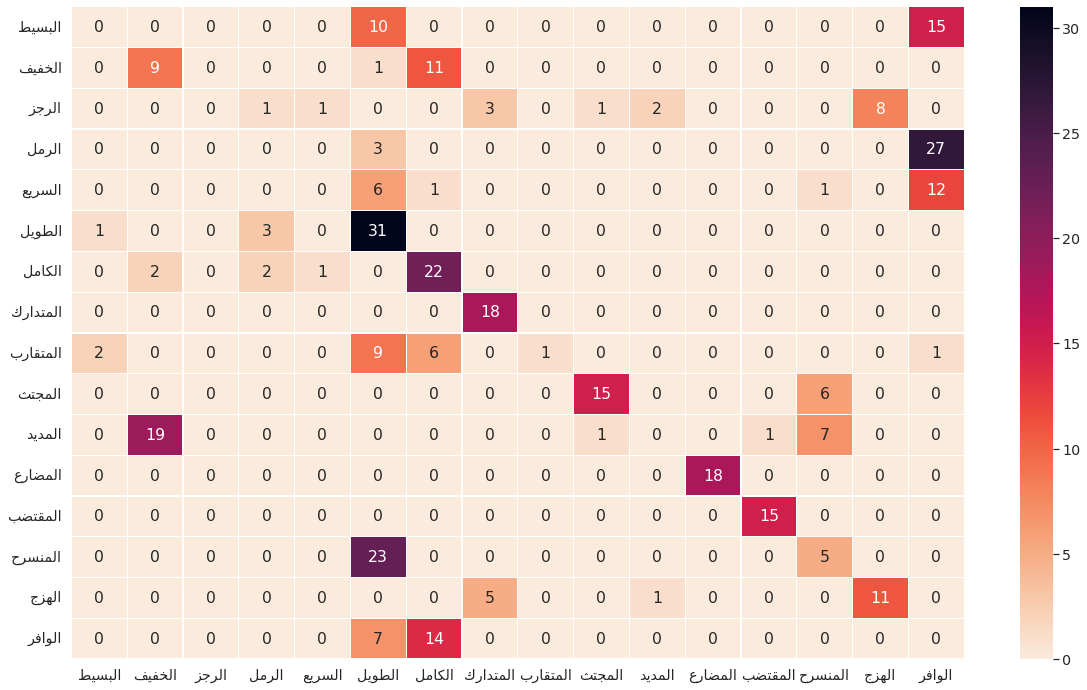

In [27]:
plt.figure(figsize = (20,12))
sns.set(font_scale=1.3)
# sns.heatmap(matrix, annot=True,linewidths=2)
sns.heatmap(
    matrix,
    annot=True,
    linewidths=.2, 
    cmap="rocket_r",
    xticklabels=[get_display(arabic_reshaper.reshape(meter_class_to_label[i])) for i in range(16)], 
    yticklabels=[get_display(arabic_reshaper.reshape(meter_class_to_label[i])) for i in range(16)],
  )

## On the benchmark

In [29]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

In [30]:
test_dataset = load_dataset("MagedSaeed/arabic_poetry_speech_benchmark", use_auth_token=True)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/MagedSaeed___parquet/MagedSaeed--arabic_poetry_speech_benchmark-34fade01103d0c39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
bahr_en_ar_map = {'baseet':'البسيط',
 'hazaj':'الهزج',
 'kamel':'الكامل',
 'khafeef':'الخفيف',
 'madeed':'المديد',
 'mudhare':'المضارع',
 'mujtath':'المجتث',
 'munsareh':'المنسرح',
 'muqtatheb':'المقتضب',
 'mutadarak':'المتدارك',
 'mutakareb':'المتقارب',
 'rajaz':'الرجز',
 'ramal':'الرمل',
 'saree':'السريع',
 'taweel':'الطويل',
 'wafer':'الوافر',
 }

In [32]:
def predict(example):
  example['predicted'] = classifier.classify(speech_array=example["speech_array"])
  example['bahr_ar'] = bahr_en_ar_map[example['bahr']]
  return example

In [33]:
test_dataset = test_dataset.map(predict)

  0%|          | 0/268 [00:00<?, ?ex/s]

In [34]:
def compute_metrics(preds,labels):
    named_preds = [meter_class_to_label[item] for item in preds]
    named_labels = [meter_class_to_label[item] for item  in labels]
    print('labels:',named_labels)
    print('predictions:',named_preds)
    acc = accuracy_score(named_labels, named_preds)
    report = classification_report(named_labels, named_preds)
    matrix = confusion_matrix(named_labels, named_preds)
    print(matrix)
    print('clasification report',report)
    print('accuracy',acc)
    return matrix

In [35]:
matrix = compute_metrics(
    preds=[example['predicted'] for example in test_dataset['train']],
    labels=[meter_label_to_class[example['bahr_ar']] for example in test_dataset['train']]
)

labels: ['الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الهزج', 'الرمل', 'الرمل', 'الرمل', 'الرمل', 'الرمل', 'الرمل', 'الرمل', 'الرمل', 'الرمل', 'الرمل', 'الرمل', 'الرمل', 'الرمل', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المتقارب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'المقتضب', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'الكامل', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المديد', 'المد

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


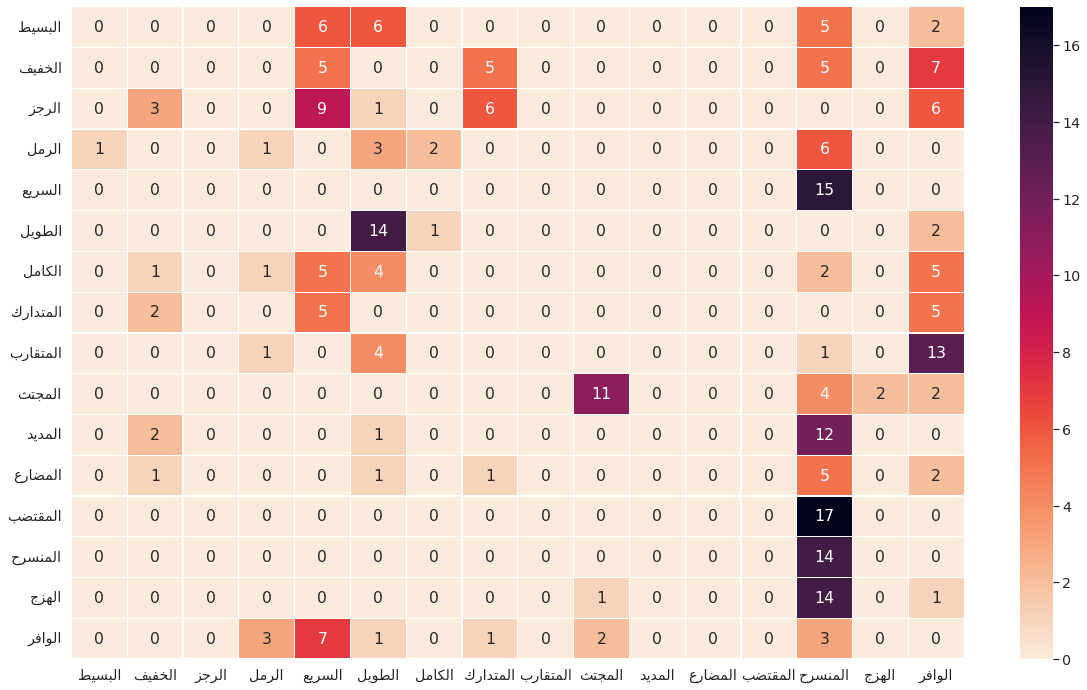

In [36]:
plt.figure(figsize = (20,12))
sns.set(font_scale=1.3)
# sns.heatmap(matrix, annot=True,linewidths=2)
sns.heatmap(
    matrix,
    annot=True,
    linewidths=.2, 
    cmap="rocket_r",
    xticklabels=[get_display(arabic_reshaper.reshape(meter_class_to_label[i])) for i in range(16)], 
    yticklabels=[get_display(arabic_reshaper.reshape(meter_class_to_label[i])) for i in range(16)],
  )